# Pendulum-1: Forward Problem


## Theoretical Background

### Objective

In this tutorial we will train a simple neural netowrk to predict the motion of a simple pendulum of length $L$ undergoing large displacement $\theta$. This is what is termed as the **forward problem**. PINNs can also be used for discover of ODEs/PDEs, which is called **inverse problem**, which shall be described in the next tutorial notebook. <br>

The motion of a simple pendulum can be described using the following ordinary differential equation (ODE):

$$ \displaystyle{ \frac{d^2\theta}{dt^2} + \frac{g}{L} \sin \theta = 0 } $$

where, $g$ is the acceleration due to gravity.

**Note:** <br>
For small angular displacement, we can assume $\sin \theta \approx \theta$. This will simplify the the governing equation and allow us to obtain an exact solution $ \theta(t) = \theta_0 \cos \left( \sqrt{g/L} \times t \right) $. But since we are considering large displacement, this simplification cannot be use and thus we need to solve the ODE. Go through the [aritcle](https://www.acs.psu.edu/drussell/Demos/Pendulum/Pendulum.html) for additional theoretical background and visualization.


### Motivation

ODEs are generally solved using numerical methods such as **RK45** (which we will also be using for validation). These are *time marching schemes*, meaning, to know the displacement angle of the pendulum at say time $t = 5s$, we will have to run the solver from $t = 0$ to $t= 3s$. Such *time marching* techniques can be computationally very expensive and require long simulation time for more complex problems. <br> 

On the other hand, a PINN model, once trained, will be able to predict the displacement angle of the pendulum at any time (within the trained domain), without have to compute from time $t = 0$. This can be of immense advantage for more complex problems. Moreover, unlike the traditional neural networks, PINNs do not require trainig dataset. More concretely, we do not need to generate data from a numerical method and feed it to the neural network for training. Instead, we will only use the initial conditions, boundary conditions and the governing equations (at various time-steps) for training PINNs.

In summary, follow are the primary advantages of PINNs:
- Can predict the state of the system at a future time $t > 0$, without have to compute the states of the system leading up to that point in time.
- Do not require training dataset from simulation/experiment (for forward problems).


### Methodology

Let us consider a simple pendulum of lenght $L = 0.5 m$ and initial displacement $\theta_0 = 45\degree$. We will assume $g = 9.81 \ m/s^2$. Thus, we can state the following regarding our system:

**Initial Conditions :**
$$ \theta_{0} = 45\degree $$

**Boundary Condition :**
$$ \displaystyle{ \frac{d\theta_{0}}{dt} = 0 } $$

**Governing Equation :**
$$ \displaystyle{ \frac{d^2\theta}{dt^2} + \frac{g}{L} \sin \theta = 0 } $$

<br>

Since we are assuming the pendulum to be stationary at the initial position ($t=0$), its angular velocity is also zeros ( $\omega_0 = d\theta_0/dt = 0$), which is our boundary condition. The governing equation, which is an ODE, must be satisfied for all time $t>0$. Thus:

- The above 3 equations will be the *loss function* of the neural network.
- The governing ODE *infroms* the neural network regrading the physics.
- The *initial condition* and *boundary condition* serve as contraints to prevent the neural network from converging to a trivial solution by pushing the weights and biases close to $\approx 0$ value, thus effectively making $loss \approx 0$.


## Import Libraries

In [1]:
# For numerical method
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# For PINNs
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Numerical Method (RK45)


We will first solve the governing ODE numerically using `scipy` library. 

Understanding the implementation of the numerical method is not very relevant for PINNs. So don't worry if you do not understand it. We will use the output of the numerical method for validating the prediction of PINNs. Once again, this data will NOT be used for training PINNs.


### Function definition

In [2]:
# Define the ODE system for the pendulum
def pendulum_ode(t, y, g, L):
    """
    Defines the system of ODEs for the pendulum.
    
    Parameters:
    - t: Time variable (not used explicitly as the system is autonomous).
    - y: Array where y[0] is theta (angle) and y[1] is omega (angular velocity).
    - g: Acceleration due to gravity.
    - L: Length of the pendulum.
    
    Returns:
    - dydt: Array containing derivatives [dtheta/dt, domega/dt].
    """
    theta, omega = y  # Unpack theta and omega from the state array
    dtheta_dt = omega  # Angular velocity
    domega_dt = -(g / L) * np.sin(theta)  # Angular acceleration
    return [dtheta_dt, domega_dt]


### Define System Parameters

In [3]:
# Parameters
g = 9.81 # Acceleration due to gravity (m/s^2)
L = 0.5  # Length of the pendulum (meters)
theta0 = np.radians(45)  # Initial angle (converted to radians)
omega0 = 0  # Initial angular velocity (rad/s)

# Time parameters
t0 = 0  # Initial time (seconds)
t_end = 5  # End time (seconds)


### Solve ODE

In [4]:
# Initial state
y0 = [theta0, omega0]  # Initial conditions: [theta, omega]

# Solve the ODE using solve_ivp (Runge-Kutta method is default)
solution = solve_ivp(
    pendulum_ode,  # Function defining the ODE system
    [t0, t_end],   # Time span for the solution
    y0,            # Initial conditions
    t_eval=np.linspace(t0, t_end, 501),  # Time points where the solution is evaluated
    args=(g, L)    # Additional arguments passed to the ODE function
)

# Extract results
t_values = solution.t  # Time points
theta_values = solution.y[0]  # Theta values (angular displacement)


### Validation Dataset

For the validation of PINNs solution, we will extract 51 datapoints from the the RK4 numerical method solution.

In [5]:
# Total number of elements to extract
num_samples = 51

# Compute evenly spaced indices
indices = np.linspace(0, len(t_values) - 1, num_samples, dtype=int)

# Validation data
t_valid = torch.from_numpy(t_values[indices]).view(-1, 1)
theta_valid = torch.from_numpy(theta_values[indices]).view(-1, 1)


### Plot Numeric Solution and Validation Dataset

C:\Users\E40065690\AppData\Local\Temp\ipykernel_15344\3889465636.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.scatter(t_valid, np.degrees(theta_valid), label="Validation Data")


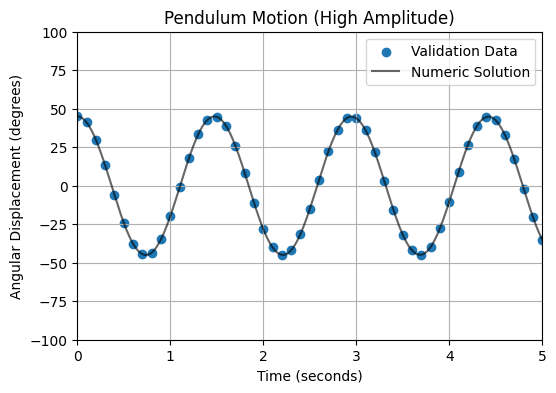

In [6]:
# Visualize dataset
plt.figure(figsize=(6, 4))
plt.scatter(t_valid, np.degrees(theta_valid), label="Validation Data")
plt.plot(t_values, np.degrees(theta_values), label="Numeric Solution", color="black", alpha=0.6)
plt.legend(loc="upper right")
plt.title("Pendulum Motion (High Amplitude)")
plt.xlabel("Time (seconds)")
plt.ylabel("Angular Displacement (degrees)")
plt.axis([0, t_end, -100, 100])
plt.grid()
plt.legend()
plt.show()


## PINNs

### Network Architecture

We wish to have a neural network that can predict the position of a pendulum ($\theta$) at any time $0 \leq t \leq 5 \ s$, for predifined value of $g = 9.8 \ m/s^2$ and $L = 0.5 \ m$ at any time `t`

**Input :** time $t$ (single feature)

**Hidden Layers :** 3 hidden layers with 32 neurons each.

**Output :** angular displacement $\theta_t$ of the pendulum at time $t$


### `Class` Definition for PINN Model

In [7]:
class PINN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


### `Functions` for Printing Losses and Visualizing Training Progress

In [8]:
# Print Losses
def print_training_losses(epoch, loss_total, loss_1, loss_2, loss_3):
    print("#"*17)
    print(f"Epoch = {epoch+1}")
    print("#"*17)
    print(f"Loss Total  = {loss_total.detach():.4f}")
    print(f"Loss 1      = {loss_1.detach():.4f}")
    print(f"Loss 2      = {loss_2.detach():.4f}")
    print(f"Loss 3      = {loss_3.detach():.4f}")
    print("#"*17)

    return()

# Plot comparison of PINN's prediction with validation data  
def plot_training_progress(epoch, model_pinns, t_valid, theta_valid):
       
    # Theta prediction for validation dataset
    theta_obs_pred = model_pinns(t_valid).detach()

    plt.figure(figsize=(5, 2.5))
    plt.scatter(t_valid[:, 0], np.degrees(theta_valid[:,0]), label="Validation Data", alpha=0.6)
    plt.plot(t_valid[:, 0], np.degrees(theta_obs_pred[:,0]), label="PINN Solution", color="g")

    plt.title(f"Training step {epoch+1}", fontsize=10)        
    plt.xlabel("Time (in s)", fontsize=8)
    plt.ylabel("Theta (in deg)", fontsize=8)

    plt.axis([0, t_end, -100, 100])
    plt.legend(fontsize="small")
    plt.show()

    return()


### Training

Let us recollect the equations we will be using for computing the loss for training our PINN model:

**Initial Conditions :**
$$ \theta_{0} = 45\degree $$

**Boundary Condition :**
$$ \displaystyle{ \frac{d\theta_{0}}{dt} = 0 } $$

**Governing Equation :**
$$ \displaystyle{ \frac{d^2\theta}{dt^2} + \frac{g}{L} \sin \theta = 0 } $$

<br>

**Loss Function :** <br>
The derivatives $d\theta/dt$ and $d^2\theta/dt^2$ will be computed by leveraging PyTorch's automatic differention capibility via its inbuilt function `torch.autograd`. Our training dataset comprises of $51$ uniformaly distributed data points in the domain $t \in [0,\ 5]$. We will compute the following three losses:
- `loss_1` : Physics Loss; Using the governing equation for all $t>0$.
- `loss_2` : Initial Condition Loss; For time $t = 0$.
- `loss_3` : Boundary Condition Loss; For time $t = 0$.

The magnitude of the above three losses vary largely in magnitude and thus each of them will be multiplied with a weight coefficient `coeff_i` which has been found after some trial and error. 


#################
Epoch = 1
#################
Loss Total  = 77.3005
Loss 1      = 4.2732
Loss 2      = 62.9393
Loss 3      = 10.0880
#################


C:\Users\E40065690\AppData\Local\Temp\ipykernel_15344\3986650953.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.scatter(t_valid[:, 0], np.degrees(theta_valid[:,0]), label="Validation Data", alpha=0.6)
C:\Users\E40065690\AppData\Local\Temp\ipykernel_15344\3986650953.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(t_valid[:, 0], np.degrees(theta_obs_pred[:,0]), label="PINN Solution", color="g")


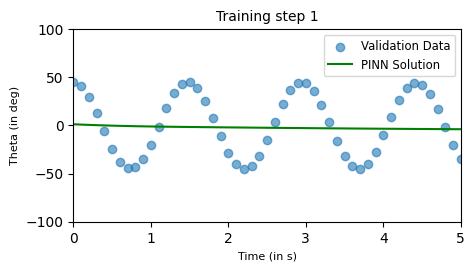

#################
Epoch = 5000
#################
Loss Total  = 1.5703
Loss 1      = 1.5330
Loss 2      = 0.0373
Loss 3      = 0.0000
#################


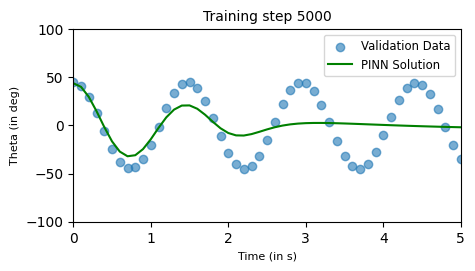

#################
Epoch = 10000
#################
Loss Total  = 1.4034
Loss 1      = 1.3730
Loss 2      = 0.0304
Loss 3      = 0.0000
#################


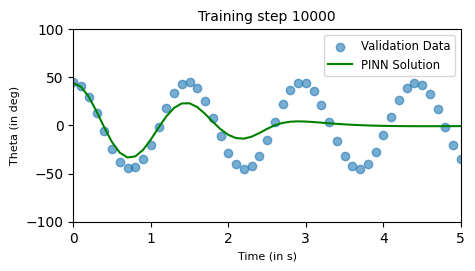

#################
Epoch = 15000
#################
Loss Total  = 1.1607
Loss 1      = 1.1411
Loss 2      = 0.0196
Loss 3      = 0.0000
#################


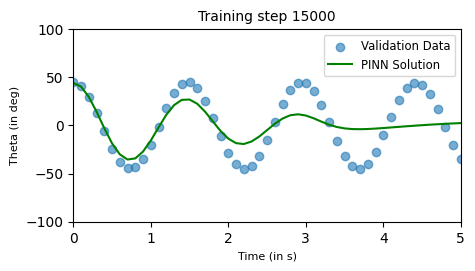

#################
Epoch = 20000
#################
Loss Total  = 0.1851
Loss 1      = 0.1795
Loss 2      = 0.0009
Loss 3      = 0.0047
#################


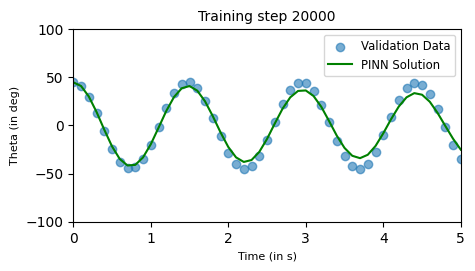

#################
Epoch = 25000
#################
Loss Total  = 0.0049
Loss 1      = 0.0048
Loss 2      = 0.0000
Loss 3      = 0.0000
#################


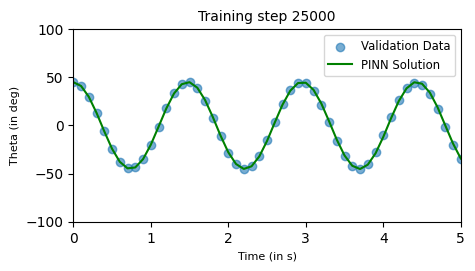

In [9]:
# Ensure all tensors have the correct dtype
t_valid = t_valid.float()
theta_valid = theta_valid.float()

# Set random seed for result Reproducibility
torch.manual_seed(42)

# Define a neural network to train
model_pinns = PINN(1, 1, 32, 3)

# Define training points over the entire domain, for the physics loss
t_physics = torch.linspace(t0, t_end, 51).view(-1,1).requires_grad_(True)

# Initial condition
theta_init = torch.from_numpy( np.radians(45).reshape(1, 1) ) # in radians
dtheta_dt_init = torch.zeros(1, 1) # in rad/s

# Define the optimizer with separate parameter groups
optimiser = torch.optim.Adam([
    {'params': model_pinns.parameters(), 'lr': 1e-3},  # Learning rate for the neural network
])

# Weight coefficients for various losses
coeff_1 = 1     # weight coeff for "loss_1" (physics loss)
coeff_2 = 100   # weight coeff for "loss_2" (initial condition)
coeff_3 = 1000  # weight coeff for "loss_3" (boundary condition)

##############
for epoch in range(25000):
    
    optimiser.zero_grad()

    # compute physics loss
    theta_pred = model_pinns(t_physics)
    dtheta_dt_pred = torch.autograd.grad(theta_pred, t_physics, torch.ones_like(theta_pred), create_graph=True)[0]
    d2theta_dt2_pred = torch.autograd.grad(dtheta_dt_pred, t_physics, torch.ones_like(dtheta_dt_pred), create_graph=True)[0]
    loss_1 = coeff_1 * torch.mean( ( d2theta_dt2_pred[:-1] + g/L*torch.sin(theta_pred[:-1]) )**2 ) # for all t > 0 
    
    # initial condition (theta = 45 deg)
    loss_2 = coeff_2 * torch.mean((theta_pred[0] - theta_init)**2)

    # boundary condition (dtheta_dt = 0)   
    loss_3 = coeff_3 * torch.mean((dtheta_dt_pred[0] - dtheta_dt_init)**2)
    
    # backpropagate joint loss, take optimiser step
    loss_total = loss_1 + loss_2 + loss_3
    loss_total.backward()
    optimiser.step()
    
    # plot the result as training progresses
    if (epoch+1) % 5000 == 0 or epoch == 0:
        print_training_losses(epoch, loss_total, loss_1, loss_2, loss_3)
        plot_training_progress(epoch, model_pinns, t_valid, theta_valid)
        

## Inference

You can see how the losses corresponding to initial condition and boundary condition force the PINN to first match the validation dataset at $t=0$ and then as the training progresses, the physics loss helps the model converge for time $t>5$. 

Now that our PINN model is trained, we can inference it for any time $t$ and get swift response as show in the cell below:

In [10]:
t_test = 3 * torch.ones(1, 1)
theta_test_pred = model_pinns(t_test) # inference (in radians)
theta_test_pred = np.degrees( theta_test_pred[0][0].detach().numpy() ) # convert to degrees

print("#"*17)
print(f"For t = {t_test[0][0].detach():.2f} sec, the pendulum displacement is {theta_test_pred:.2f} degrees.")
print("#"*17)


#################
For t = 3.00 sec, the pendulum displacement is 44.42 degrees.
#################
